In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=1000, tau=1e-2, phi=phi, name='d1')
d2 = Population(N=1000, tau=1e-2, phi=phi, name='d2')
pops = np.array([ctx, d1])

# patterns 
S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=114) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,d1.size, seed=29) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])
patterns = [patterns_ctx, patterns_bg]

# connectivity probabilities
cp = np.array([[0.05,  0.05], 
               [0.05, 0.05]])
cw = np.array([[0, 0],
               [0, 0]])
A = np.array([[4, 1],
             [.1, 4]])
plasticity_rule = np.array([[0, 0],
                          [1, 0]])

J = set_connectivity(pops, cp, cw, A, plasticity_rule, patterns, plasticity)

network = RateNetwork(pops, J, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors


0 0 0


100%|██████████| 1000/1000 [00:00<00:00, 28929.03it/s]
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Storing sequences


0 1 1


100%|██████████| 1/1 [00:00<00:00, 25.30it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Storing attractors


1 0 0


100%|██████████| 1000/1000 [00:00<00:00, 27494.80it/s]
INFO:connectivity:Building connections from d1 to d1
INFO:connectivity:Storing attractors


1 1 0


100%|██████████| 1000/1000 [00:00<00:00, 28778.18it/s]


In [4]:
init_input_ctx = phi(patterns_ctx[0][0])
init_input_bg = phi(patterns_bg[0][0])
# init_input_ctx = np.random.normal(net_ctx.size)
# init_input_bg = np.random.normal(net_bg.size)
T=10
mouse = ReachingTask()
network.simulate_euler2(mouse, T, init_input_ctx, init_input_bg, 
                        patterns_ctx[0], patterns_bg[0], detection_thres=.23,
                        noise1=.13, noise2=.13)

INFO:network:Integrating network dynamics
100%|██████████| 9999/9999 [00:06<00:00, 1584.04it/s]


In [5]:
# overlaps = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
overlaps_ctx = sequences_ctx[0].overlaps(network.pops[0])
overlaps_bg = sequences_bg[0].overlaps(network.pops[1])

INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 156.31it/s]
INFO:sequences:Computing overlaps
100%|██████████| 3/3 [00:00<00:00, 159.60it/s]


In [6]:
sns.set_style('white') 
colors = sns.color_palette('deep')


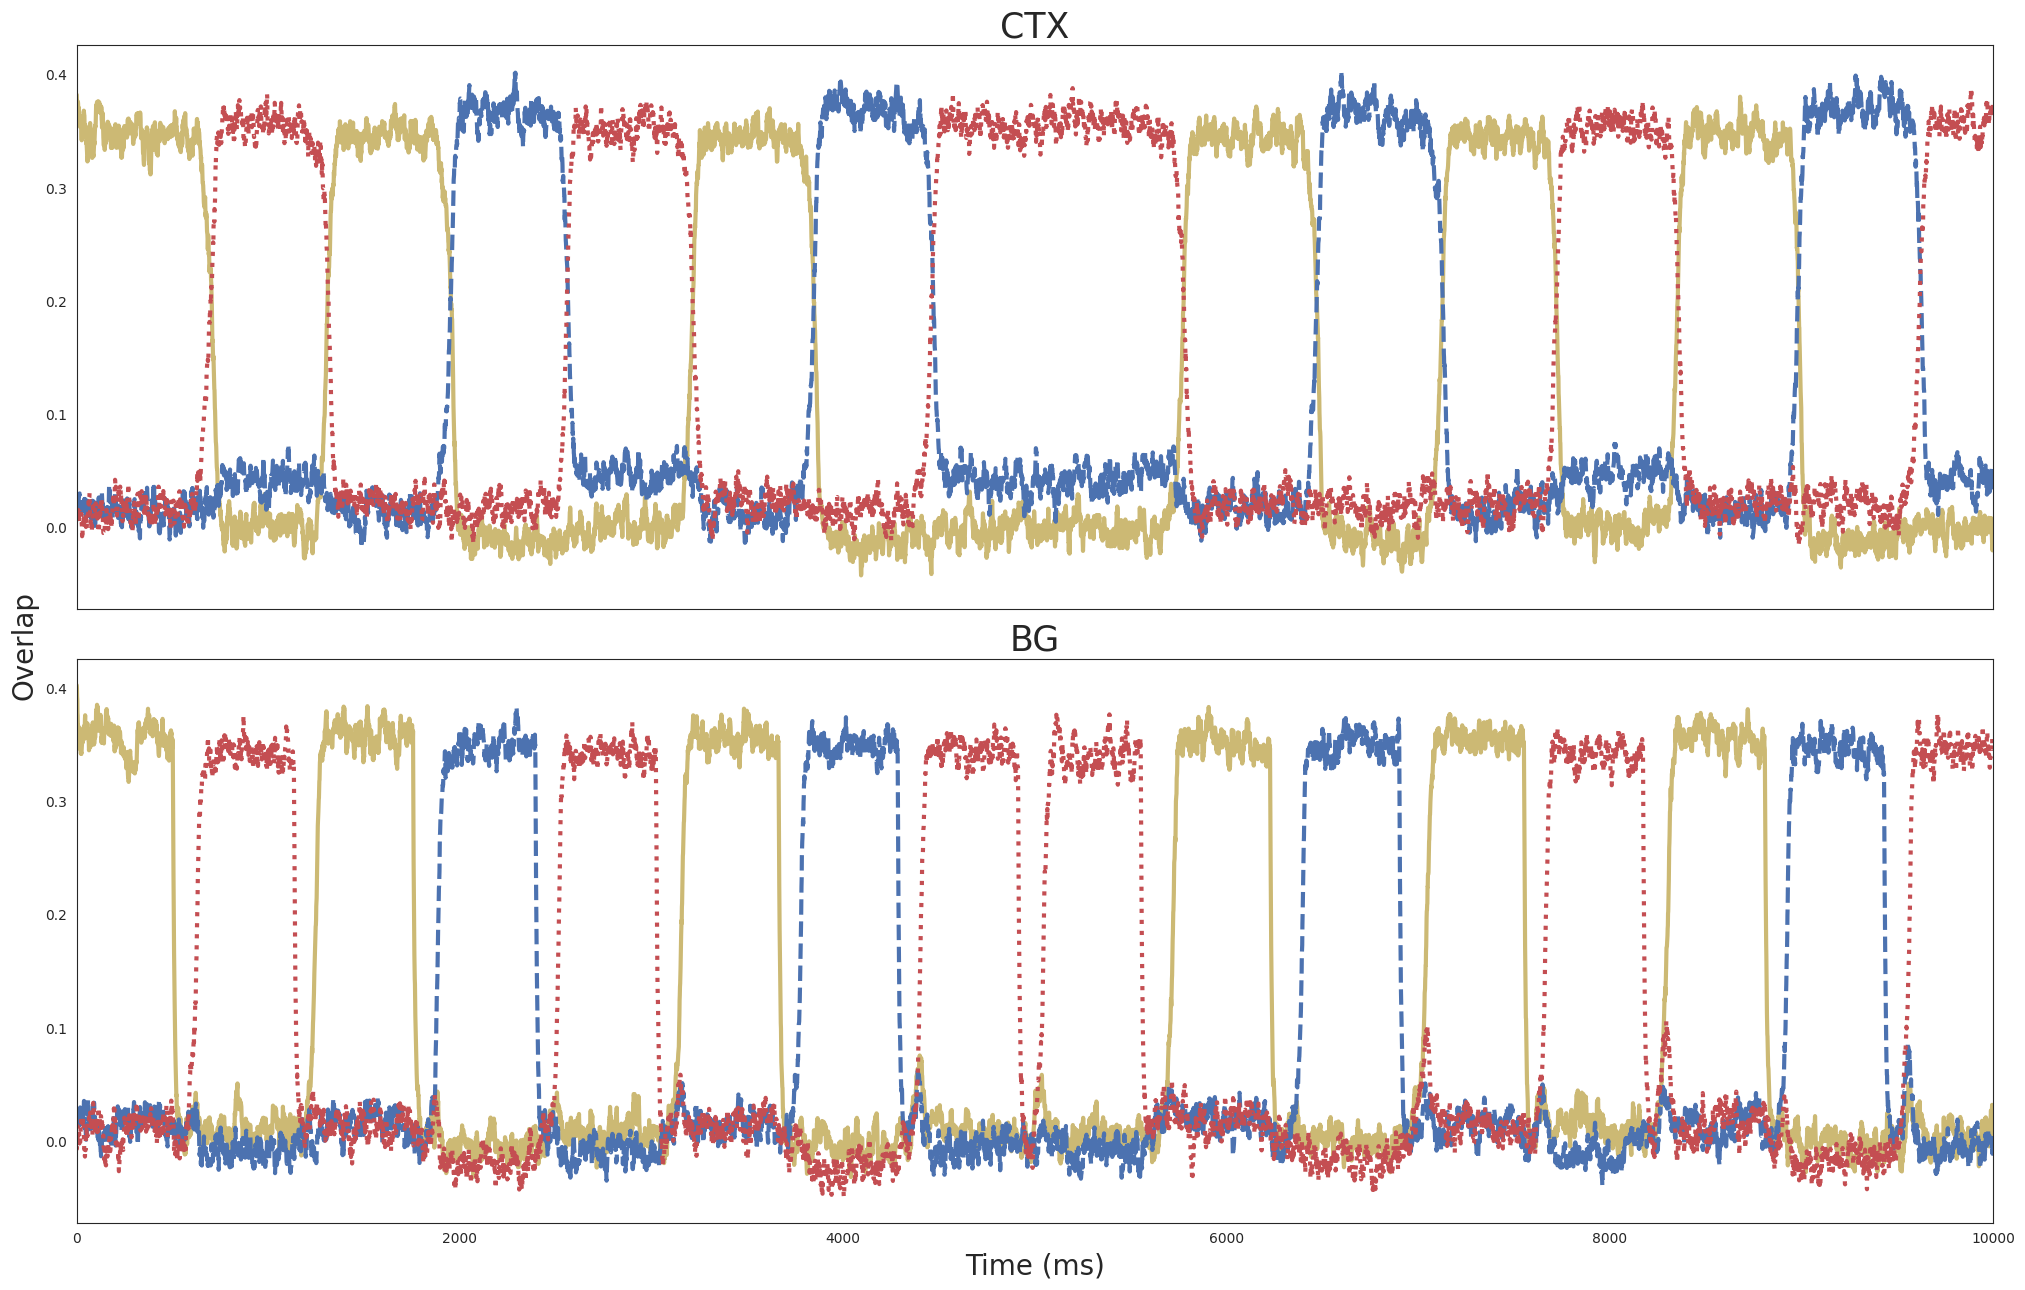

In [7]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 10000))
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('./seq1.svg', bbox_inches = "tight", format='svg')

plt.show()
